<a href="https://colab.research.google.com/github/M-ballabio1/DataScience_ML_DL-projects/blob/main/DataScienceProjects/3.ARIMA_model%20-%20Trading_Volume_(Finance)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.4 MB/s 
     |████████████████████████████████| 9.8 MB 45.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
import numpy as np
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
import statsmodels as sm
import seaborn as sns
from pmdarima.arima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


import warnings 
warnings.filterwarnings("ignore")

In [3]:
from google.colab import files 

df = files.upload()

Saving ABBV_data.csv to ABBV_data.csv


In [50]:
df = pd.read_csv('ABBV_data.csv')
print(df)


            date    open     high      low   close    volume  Name
0     2013-02-08   36.37   36.420   35.825   36.25  13858795  ABBV
1     2013-02-11   36.13   36.180   35.750   35.85   6031957  ABBV
2     2013-02-12   35.77   35.900   35.200   35.42   7473991  ABBV
3     2013-02-13   35.42   35.570   35.150   35.27   4860053  ABBV
4     2013-02-14   35.05   36.730   35.010   36.57   7570052  ABBV
...          ...     ...      ...      ...     ...       ...   ...
1254  2018-02-01  112.24  117.530  112.230  116.34   9943452  ABBV
1255  2018-02-02  115.50  117.930  114.920  115.17   7184413  ABBV
1256  2018-02-05  113.00  115.535  109.400  109.51   9827825  ABBV
1257  2018-02-06  104.91  113.520  101.000  111.20  14107829  ABBV
1258  2018-02-07  111.52  116.850  111.380  113.62  10030837  ABBV

[1259 rows x 7 columns]


In [7]:
df['date'] = pd.to_datetime(df['date'])

In [8]:
df

,date,open,high,low,close,volume,Name
0,2013-02-08,36.37,36.420,35.825,36.25,13858795,ABBV
1,2013-02-11,36.13,36.180,35.750,35.85,6031957,ABBV
2,2013-02-12,35.77,35.900,35.200,35.42,7473991,ABBV
3,2013-02-13,35.42,35.570,35.150,35.27,4860053,ABBV
4,2013-02-14,35.05,36.730,35.010,36.57,7570052,ABBV
...,...,...,...,...,...,...,...
1254,2018-02-01,112.24,117.530,112.230,116.34,9943452,ABBV
1255,2018-02-02,115.50,117.930,114.920,115.17,7184413,ABBV
1256,2018-02-05,113.00,115.535,109.400,109.51,9827825,ABBV
1257,2018-02-06,104.91,113.520,101.000,111.20,14107829,ABBV


In [51]:
df_mean = ((df.iloc[:,2]+df.iloc[:,3])/2)
df.insert(3, "mean", df_mean, allow_duplicates=False)

In [16]:
df.describe()

,open,high,mean,low,close,volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.00000,1.259000e+03
mean,60.802801,61.474133,60.825704,60.177275,60.86444,7.870683e+06
std,13.663931,13.859815,13.698183,13.551290,13.73038,5.746644e+06
min,35.050000,35.570000,35.360000,35.010000,35.27000,1.747000e+06
25%,52.680000,53.200000,52.695000,52.035000,52.65000,4.877665e+06
50%,60.040000,60.870000,60.175000,59.390000,60.17000,6.707435e+06
75%,65.720000,66.235000,65.760000,65.205000,65.74500,9.309264e+06
max,121.500000,125.860000,121.565000,118.980000,123.21000,1.227409e+08


In [17]:
#Conta i valori nulli
df.isnull().value_counts()

date   open   high   mean   low    close  volume  Name 
False  False  False  False  False  False  False   False    1259
dtype: int64

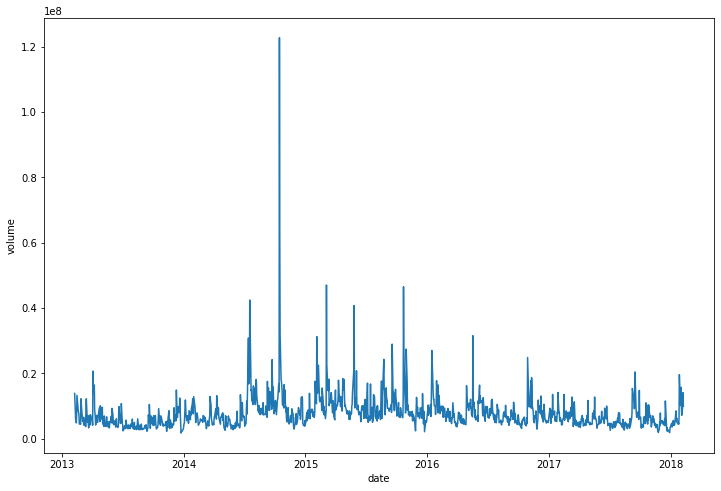

In [23]:
#Plot Volume di scambi
plt.figure(figsize=(12,8))
sns.lineplot(data=df, x='date', y= 'volume')

### Testing Stazionarietà

Una serie stazionaria è centrata su un valore, non ha troppi picchi e variazioni impreviste e non mostra drastici cambiamenti di comportamento da una parte all'altra.

Bisogna controllare la stazionarietà per due motivi:

*   I processi stazionari sono più facili da analizzare.
*   La maggior parte degli algoritmi di previsione presuppone che una serie sia stazionaria.




In [24]:
#Testing for stationarity for Volume  --> Troviamo che è stazionario in quanto p-value << 0.05
from pmdarima.arima import ADFTest
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.iloc[:,6])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.767429
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [26]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c")
    kpss_output = pd.Series(kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"])
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    
kpss_test(df['volume'].values)

Results of KPSS Test:
Test Statistic            0.696313
p-value                   0.013881
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


### Autocorrelazione e Autocorrelazione parziale

Interpretazione auto-correlazione: Il modello a seguito mi sta evidenziando che c'è mezza stagionalità nei dati, infatti, i valori che al t=0 sono correlati positivamente con quelli in t=53 circa. Così, come quelli in t=25 sono correlati con quelli in t=78.

Interpretazione auto-correlazione parziale:

In [29]:
volum=df.iloc[:,6]

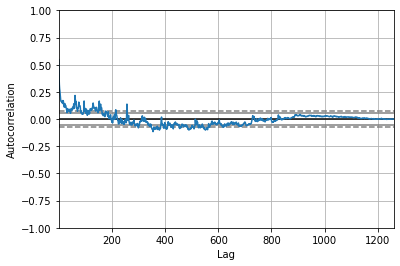

In [30]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(volum)
plt.show()

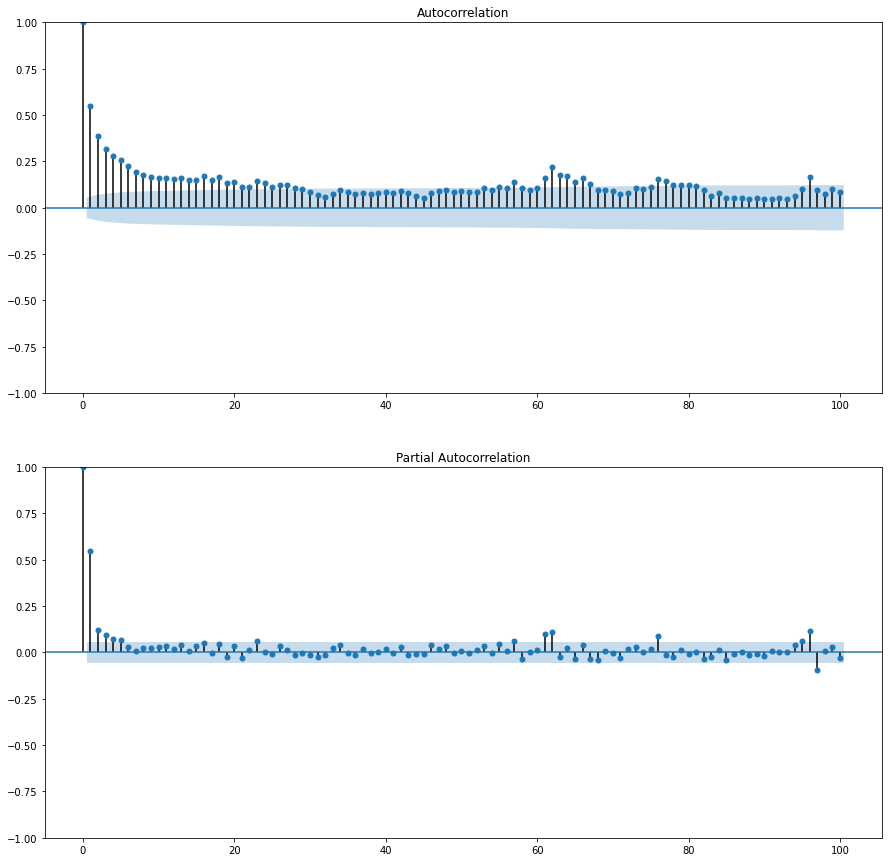

In [31]:
import statsmodels.api as sm

fig, ax = plt.subplots(2,1, figsize=(15,15))
fig = sm.graphics.tsa.plot_acf(volum, lags=100, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(volum, lags=100, ax=ax[1])
plt.show()

### ARIMA Model

ARIMA è un acronimo che sta per AutoRegressive Integrated Moving Average. ARIMA comprende due modelli al suo interno: quello autoregressivo detto AR (AutoRegressive) e quello sulle medie mobili MA (Moving Average).

La parte auto regressiva (AR) utilizza la relazione di dipendenza tra un’osservazione e un certo numero di osservazioni ritardate e viene definita nel modello dal parametro p.

Invece la parte di media mobile (MA) utilizza la dipendenza tra un’osservazione e un errore residuo da un modello a media mobile applicato alle osservazioni ritardate. Questo valore è rappresentato dal modello ARIMA con il parametro q.

All’unione di questi due modelli si aggiunge una parte integrata, che permette di gestire la differenziazione di una serie, ossia la differenza di un’osservazione da un’osservazione nella fase temporale precedente.

### Feature engineering --> smoothing Time Series

0          NaN
1          NaN
2          NaN
3          NaN
4    7958969.6
5    7846527.8
6    8298658.8
7    8423126.6
8    8903343.2
9    8287499.8
Name: volume, dtype: float64


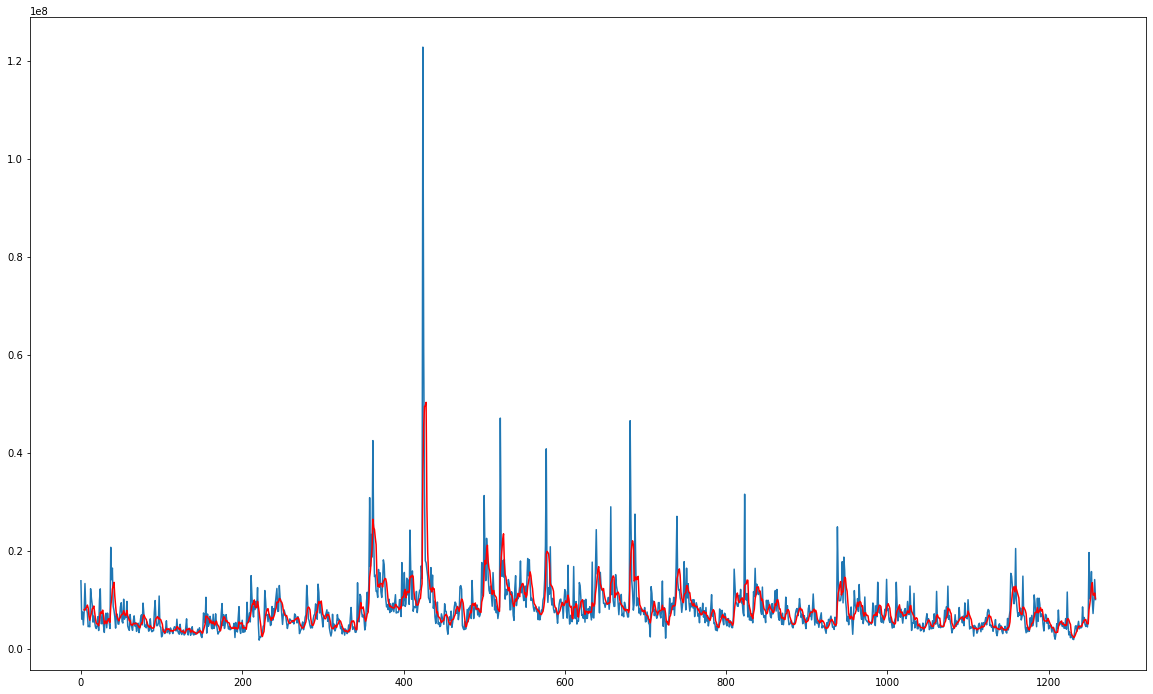

(1259,)

In [52]:
# Tail-rolling average transform
rolling = volum.rolling(window=5)
rolling_mean_vol = rolling.mean()
print(rolling_mean_vol.head(10))
# plot original and transformed dataset
plt.figure(figsize=(20,12))
volum.plot()
rolling_mean_vol.plot(color='red')
plt.show()
rolling_mean_vol.shape

In [53]:
rolling_mean_vol.drop(df.head(4).index, inplace=True)

In [54]:
rolling_mean_vol.head()

4    7958969.6
5    7846527.8
6    8298658.8
7    8423126.6
8    8903343.2
Name: volume, dtype: float64

In [56]:
rolling_mean_vol.shape

(1255,)

In [59]:
#Spliting the dataset into train (>95%) and test (ultimi 5 days)
train = rolling_mean_vol[:1250]
test = rolling_mean_vol[-6:]

Text(0, 0.5, 'Volume')

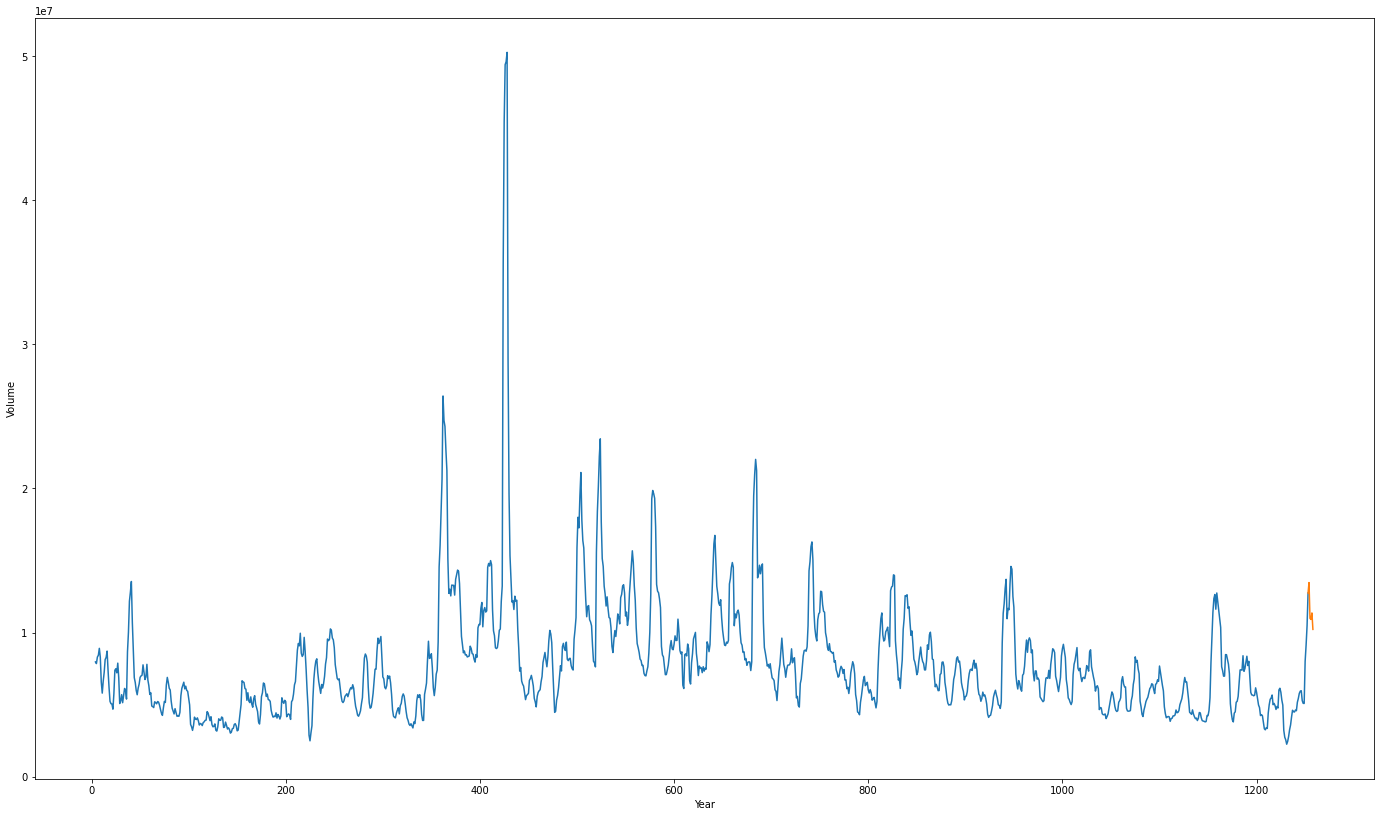

In [60]:
plt.figure(figsize=(24,14))
plt.plot(train)
plt.plot(test)
plt.xlabel('Year')
plt.ylabel('Volume')

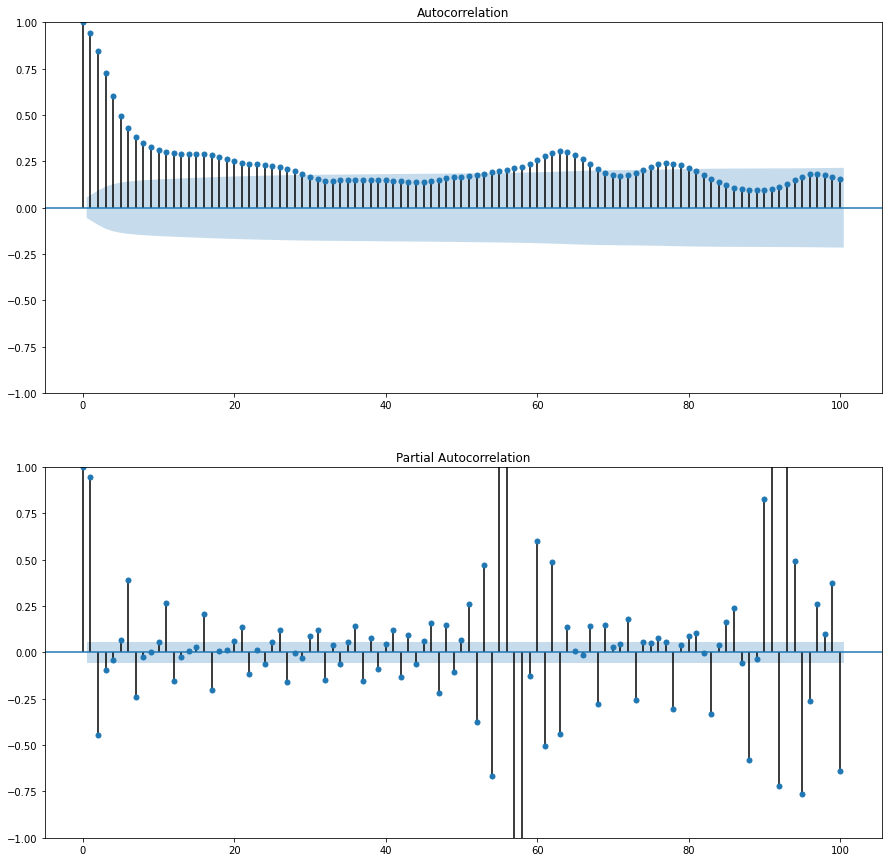

In [67]:
import statsmodels.api as sm

fig, ax = plt.subplots(2,1, figsize=(15,15))
fig = sm.graphics.tsa.plot_acf(rolling_mean_vol, lags=100, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(rolling_mean_vol, lags=100, ax=ax[1])
plt.show()

In [66]:
arima_model =  auto_arima(train,start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=7, seasonal=False, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=38901.364, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=38693.321, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=38730.474, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=38899.374, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=38694.368, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=38694.543, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=38672.130, Time=0.98 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=38669.760, Time=1.48 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=38694.701, Time=0.27 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=38589.837, Time=1.61 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=38673.714, Time=0.39 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=38407.203, Time=0.93 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=38441.994, Time=0.66 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=38402.272, Time=1.50 sec
 ARIMA(4,1,2)(0,0,0

### **COME INTERPRETARE AIC e BIC?**

##### *AIC - Akaike information criterion:*
Il criterio informativo di Akaike, o AIC, è una metrica che ci dice quanto è buono un modello. Un modello che fa previsioni migliori riceve un punteggio AIC più basso. L'AIC penalizza anche i modelli che hanno molti parametri. Ciò significa che se impostiamo l'ordine troppo alto rispetto ai dati, otterremo un valore AIC elevato. Questo ci impedisce di ottenere l'overfitting.

##### *BIC - Bayesian information criterion:*
Il criterio dell'informazione bayesiana, o BIC, è molto simile all'AIC. I modelli che si adattano meglio ai dati hanno BIC più bassi e il BIC penalizza i modelli eccessivamente complessi.

In [68]:
#Summary of the model
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1250
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -19192.141
Date:                Mon, 08 Nov 2021   AIC                          38400.281
Time:                        23:07:05   BIC                          38441.322
Sample:                             0   HQIC                         38415.711
                               - 1250                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0152      0.053     -0.289      0.773      -0.118       0.088
ar.L2          0.0803      0.064      1.261      0.207      -0.045       0.205
ar.L3          0.0877      0.036      2.436      0.015       0.017       0.158
ar.L4          0.0375      0.030      1.240      0.215      -0.022       0.097
ar.L5         -0.4579      0.005    -98.997      0.000      -0.467      -0.449
ma.L1          0.4132      0.060      6.847      0.000       0.295       0.531
ma.L2          0.1236      0.063      1.955      0.051      -0.000       0.247
sigma2      1.286e+12   1.73e-13   7.42e+24      0.000    1.29e+12    1.29e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):            846924.12
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                             5.37
Prob(H) (two-sided):                  0.00   Kurtosis:                       130.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.06e+39. Standard errors may be unstable.
"""

#### **Quello che abbiamo trovato è un modello ARIMA.**

Diamo un'occhiata ai valori estratti dal modello:

*   **Test di Jarque-Bera:** significa se ci sono oppure no abbastanza evidenze per rifiutare l'ipotesi di normalità (con il valore soglia impostato: P-value è minore di .05)
*   **Curtosi** la pesantezza delle code di una distribuzione in relazione al suo addensamento intorno al valore centrale. Il valore di riferimento è 3
*   **Skewness** misura dell’asimmetria di una distribuzione di probabilità. Il valore di riferimento è 0.
*   **Eteroschedasticità dei residui** viene testa con Goldfeld-Quandt Test. Si definisce omoschedasticità dei dati se la varianza rimane sempre costante lungo la serie ed eteroschedasticità il contrario.





In [77]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
final_model = SARIMAX(train,order=(5,1,2))
result = final_model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                 volume   No. Observations:                 1250
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -19192.141
Date:                Mon, 08 Nov 2021   AIC                          38400.281
Time:                        23:09:05   BIC                          38441.322
Sample:                             0   HQIC                         38415.711
                               - 1250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0152      0.053     -0.289      0.773      -0.118       0.088
ar.L2          0.0803      0.064      1.261      0.207      -0.045       0.205
ar.L3          0.0877      0.036      2.436      0.0

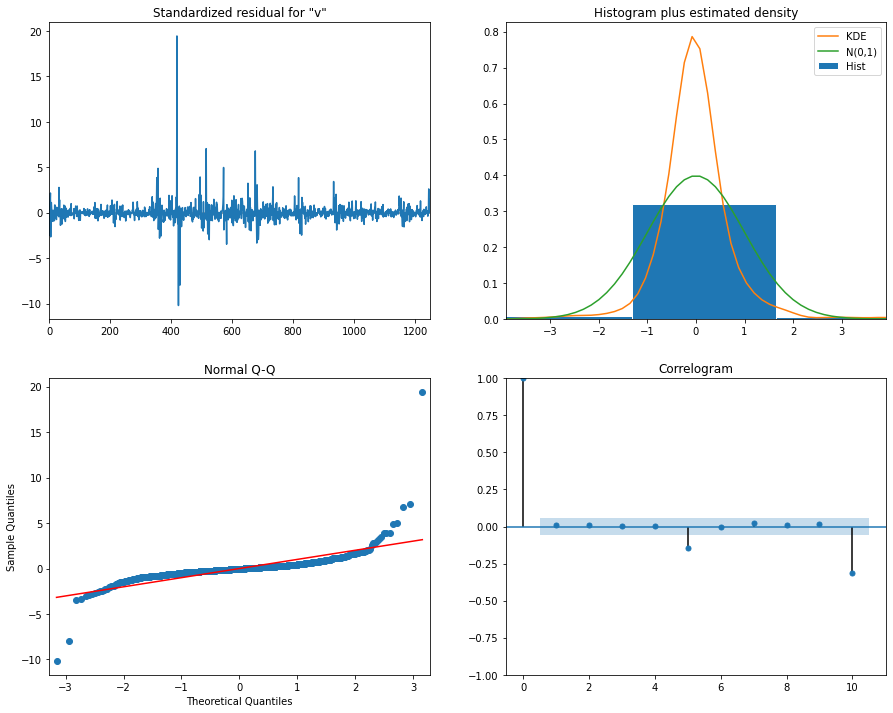

In [78]:
result.plot_diagnostics(figsize=(15, 12));

In [79]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 6),index=test.index)
prediction.columns = ['Volume']
prediction

,Volume
1253,1.377361e+07
1254,1.296585e+07
1255,1.279284e+07
1256,1.228691e+07
1257,1.121275e+07
1258,1.067164e+07


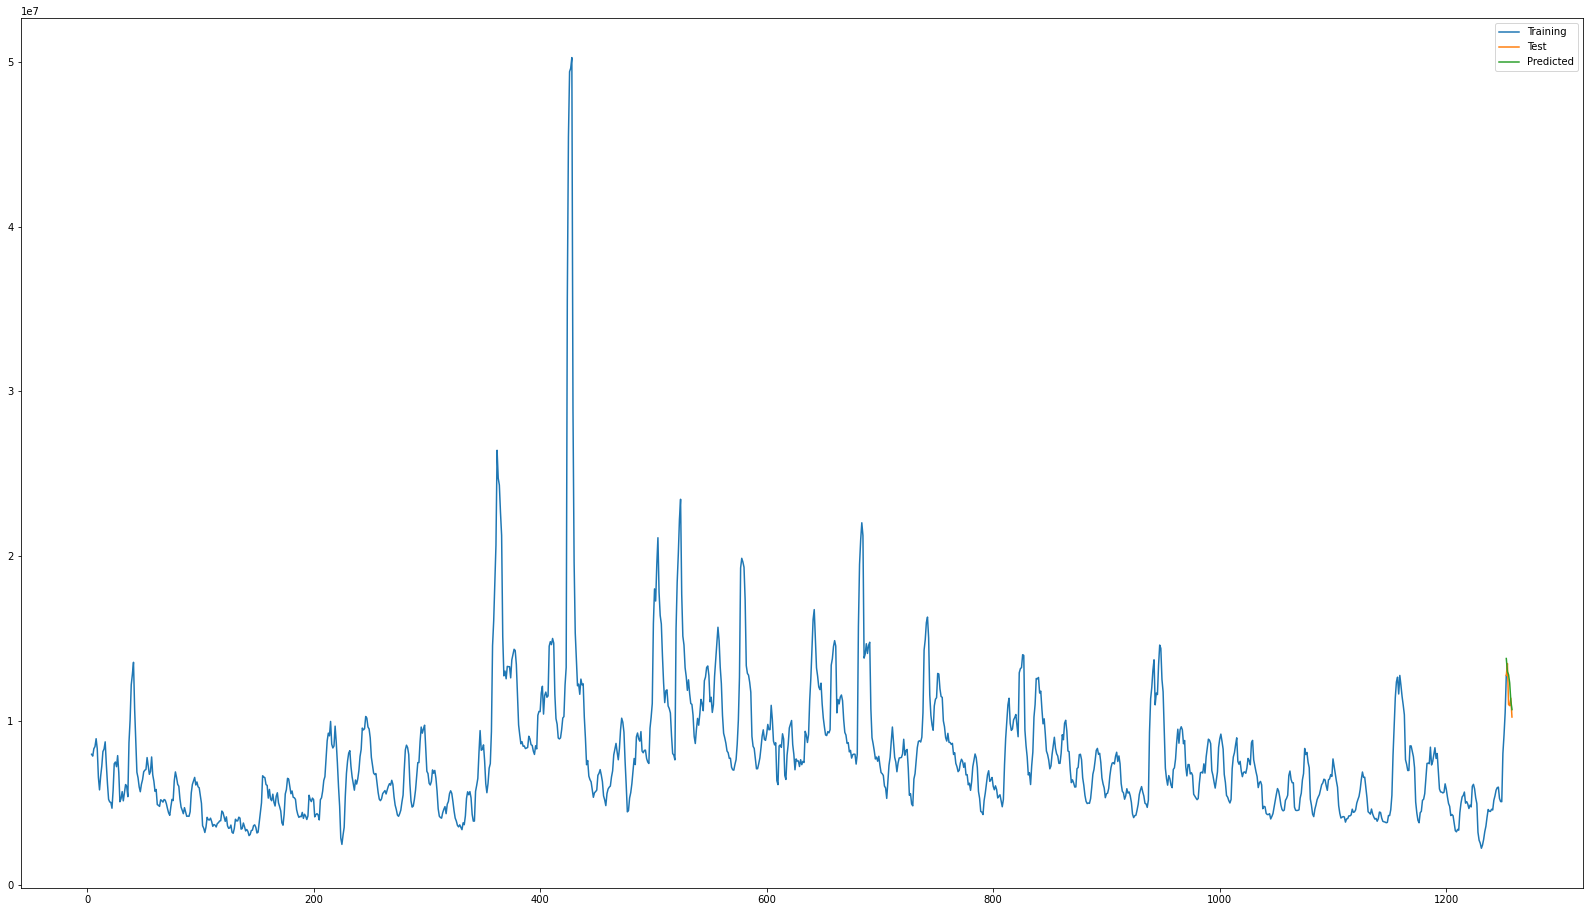

In [71]:
plt.figure(figsize=(28,16))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'Left corner')
plt.show()

In [72]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [73]:
mean_absolute_percentage_error(test, prediction)

12.244003166146083

In [74]:
from sklearn.metrics import r2_score
r2_score(test, prediction)

0.11854755430537234

In [75]:
test

1253    12744193.6
1254    13467375.2
1255    10981361.8
1256    10910389.2
1257    11361665.6
1258    10218871.2
Name: volume, dtype: float64

In [76]:
prediction

,Temperature
1253,1.377361e+07
1254,1.296585e+07
1255,1.279284e+07
1256,1.228691e+07
1257,1.121275e+07
1258,1.067164e+07
